### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import networkx as nx
from networkx.convert_matrix import from_numpy_matrix
from networkx.algorithms.centrality import degree_centrality, in_degree_centrality, out_degree_centrality, eigenvector_centrality, katz_centrality, closeness_centrality, betweenness_centrality 

import os

import imageio

### Read Cov Matrices which we will use as adj matrices

In [2]:
# We have window sizes of 7, 30, 90, 180 days available
windowsize = 90
filename_matrices = 'Adj_Matrices/Top25CC_CorMatrix_rollingwindow_'+str(windowsize)+'.csv'

In [3]:
cov_matrices = pd.read_csv(filename_matrices, index_col='date')
cov_matrices = cov_matrices.drop('CC', axis = 1).replace([np.inf, -np.inf], np.nan).fillna(0)[25*windowsize:]
cov_matrices.index = pd.to_datetime(cov_matrices.index)

In [4]:
dates = np.unique(cov_matrices.index)

In [5]:
# CCs that we use, consituents from CRIX Q1 2019
constits_latest = ['ada', 'bat', 'bch', 'bnb', 'bsv', 'btc', 'dash', 'eos', 'etc',
       'eth', 'ltc', 'miota', 'mkr', 'neo', 'okb', 'ont', 'trx', 'usdt',
       'vet', 'xem', 'xlm', 'xmr', 'xrp', 'xtz', 'zec']

### Make threshold

In [6]:
# factor is multiple of std from mean
# can be positive or negative
# can be float
factor = 0
threshold = (cov_matrices.values.flatten().mean()
             + factor * (cov_matrices.values.flatten().std()))

### Make degreeness over time table (data frame, df)

In [7]:
degree_df = pd.DataFrame(columns=constits_latest)
for date in dates:
    adj_matrix = cov_matrices.loc[date]
    # remove self-loops
    adj_matrix = np.where((adj_matrix<=1.000001) & (adj_matrix>=0.99999),0,adj_matrix)
    # replace values that are below threshold
    adj_matrix = np.where(adj_matrix <= threshold, 0, adj_matrix)
    # create undirected graph from adj_matrix
    graph = from_numpy_matrix(adj_matrix, parallel_edges=False, create_using= nx.Graph())
    # set names to crypots
    graph = nx.relabel.relabel_nodes(graph, dict(zip(range(len(constits_latest)), constits_latest)))
    # get DC
    d_C = degree_centrality(graph)
    degreeness = np.array(list(d_C.values()))
    degree_df.loc[date] = degreeness

In [8]:
top_5_cryptos = ['btc', 'eth', 'xrp', 'bch', 'eos']

### Make plots

C:\Users\justi\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


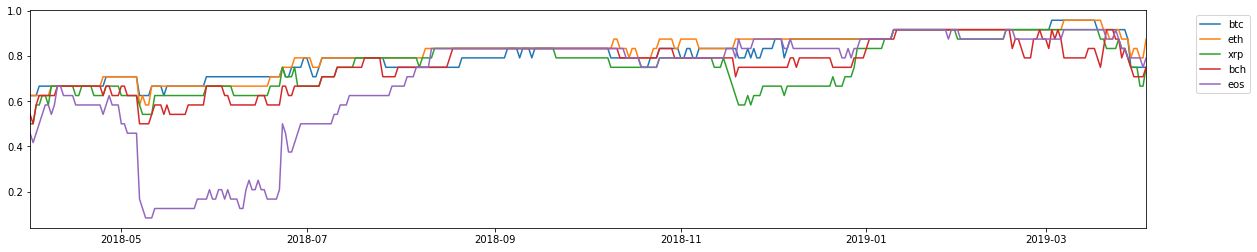

In [9]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(20,4)
for cc in top_5_cryptos:
    ax.plot(degree_df[cc], label = cc)
ax.set_xlim(dates[0], dates[-1])
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.savefig('Top_5_CC_degreeness_window_'+str(windowsize)+'.png', dpi = 150, transparent = True)
plt.show()